References:
1. Panduan Lab 5

In [142]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import cv2
import os

from typing import Union
from scipy import fftpack as fp
from skimage import color
from skimage import filters
from skimage import io
from skimage import morphology
from skimage import util
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

## **1. [30] Image Histogram**

### Diberikan dua buah kelas citra yaitu kelas hutan dan juga lautan yang terdiri dari masing-masing 4 citra untuk kedua kelas. Lakukan pengklasifikasian kedua buah citra ke dalam kelas yang sesuai dengan menggunakan fitur image histogramnya.

### a. [20] Buatlah method predict yang menerima parameter nama_file dan mengembalikan output “hutan” untuk citra yang tergolong sebagai hutan dan lautan untuk citra yang tergolong sebagai lautan. Method predict yang dibuat wajib menggunakan fitur berupa image histogram. Pengecekan dan ekstraksi fitur yang dilakukan pada setiap citra harus di automasi, tidak boleh di-hardcode untuk tiap citra.

image Tugas Lab 6 Images/histogram/sea2.jpg predicted as lautan


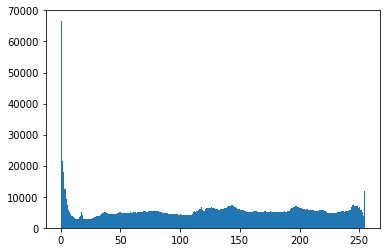


image Tugas Lab 6 Images/histogram/forest3.jpg predicted as hutan


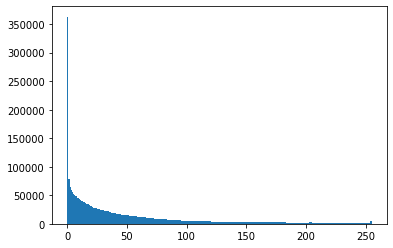


image Tugas Lab 6 Images/histogram/forest2.jpg predicted as hutan


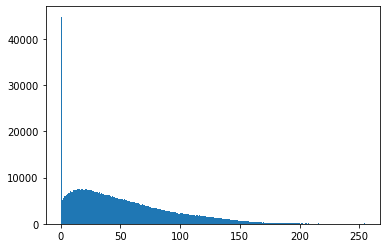


image Tugas Lab 6 Images/histogram/sea3.jpg predicted as lautan


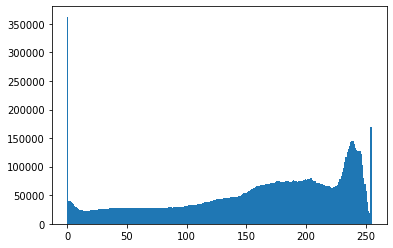


image Tugas Lab 6 Images/histogram/sea1.jpg predicted as lautan


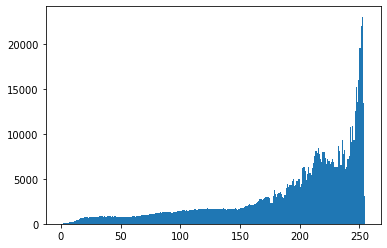


image Tugas Lab 6 Images/histogram/forest1.jpg predicted as hutan


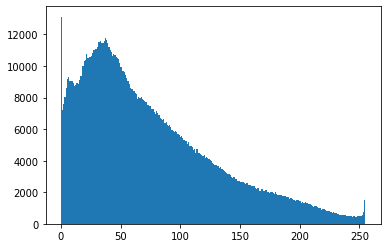


image Tugas Lab 6 Images/histogram/sea4.jpg predicted as lautan


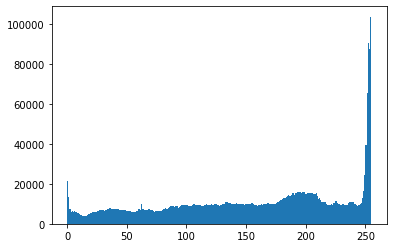


image Tugas Lab 6 Images/histogram/.DS_Store might be corrupted or not an image file
image Tugas Lab 6 Images/histogram/forest4.jpg predicted as hutan


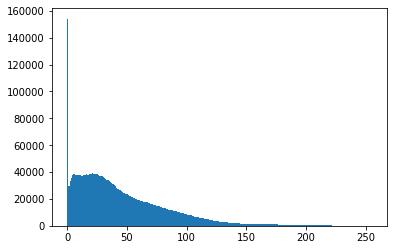

In [143]:
def predict(nama_file: str) -> Union[list, None]:
    """Method untuk memprediksi gambar adalah hutan/lautan"""
    try:
        img = io.imread(nama_file, plugin='matplotlib')
        img = util.img_as_ubyte(img)
        frequency_count = np.bincount(img.flatten())
        cum_sum = np.cumsum(frequency_count)
    except (IOError, SyntaxError):
        return None

    # lebih banyak intensitas rendah, prediksi sebagai hutan
    if cum_sum[127] > (cum_sum[-1] - cum_sum[127]):
        return [img, 'hutan']
    else:
        return [img, 'lautan']

folder = "Tugas Lab 6 Images/histogram"
for filename in os.listdir(folder):
    filename = f'{folder}/{filename}'
    prediction = predict(filename)
    if prediction:
        print(f'image {filename} predicted as {prediction[1]}')
        plt.hist(prediction[0].flatten(), 256, range=(0,255))
        plt.show()
        print()
    else:
        print(f'image {filename} might be corrupted or not an image file')

### b. [10] Jelaskan fitur yang telah Anda buat pada bagian a dan alasan Anda memilih fitur tersebut.

Pada bagian a, saya mereplikasi fungsi `predict` pada Tutorial. Hal ini dikarenakan logika yang digunakan pada tutorial, yakni siang/malam, dengan kasus hutan/lautan kurang lebih sama, di mana keduanya dapat dibedakan berdasarkan pixel intensity-nya.

Dalam kasus hutan/lautan, dapat diambil kesimpulan umum bahwa citra hutan lebih banyak memiliki intensitas rendah (daerah gelap) dibanding citra lautan. Menggunakan program yang ditulis pada Tutorial, kita bisa mengambil summation dari daerah tinggi dan rendah pada histogram, lalu membandingkannya.

## **2. [30] Hough Transformation**

### Diberikan dua buah kelas citra yaitu kelas segitiga siku siku dan juga segitiga sama sisi yang terdiri dari masing-masing 4 citra untuk kedua kelas. (Asumsikan posisi segitiga yang mungkin hanya sesuai citra yang diberikan pada dataset, tidak ada miring 10° atau semacamnya)

### a. [20] Gunakan hasil hough transformation yang telah didapatkan sebagai fitur untuk mengklasifikasikan apakah citra tersebut merupakan segitiga siku siku atau segitiga sama sisi. Manfaatkan variabel theta yang ada pada template lab untuk menentukannya. Anda dapat menggunakan cv2.HoughLines seperti yang dijabarkan pada tutorial. (Hint: Cek dalam skala apa theta dikembalikan oleh fungsi HoughLines)

In [144]:
def classify_triangle(filename: str) -> str:
    img = io.imread(filename)
    # convert image to gray
    gray = (color.rgb2gray(img) * 255).astype(np.uint8)
    # find all of the edges using canny
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    # find all of the lines using hough transformation
    lines = cv2.HoughLines(edges, 1, np.pi/180, 200)

    thetas_in_deg = []

    for line in lines:
        for _, theta in line:
            thetas_in_deg.append(np.degrees(theta))

    thetas_in_deg = list(set(map(round, thetas_in_deg)))
    thetas_in_deg.pop(0)

    if 90 in thetas_in_deg:
        return 'siku-siku'
    else:
        return 'sama sisi'

folder = "Tugas Lab 6 Images/segitiga"
for filename in os.listdir(folder):
    full_dir = f'{folder}/{filename}'
    classification = classify_triangle(full_dir)
    print(f'triangle {filename[0:-4]} is classified as {classification}')

triangle siku siku 4 is classified as siku-siku
triangle siku siku 2 is classified as siku-siku
triangle siku siku 3 is classified as siku-siku
triangle siku siku 1 is classified as siku-siku
triangle sama sisi 4 is classified as sama sisi
triangle sama sisi 3 is classified as sama sisi
triangle sama sisi 2 is classified as sama sisi
triangle sama sisi 1 is classified as sama sisi


/var/folders/4y/f7n6cknn4dd3pvy303271wjh0000gn/T/ipykernel_78999/4284499653.py:4: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  gray = (color.rgb2gray(img) * 255).astype(np.uint8)


### b. [10] Jelaskan lebih detail tentang parameter yang anda gunakan sebagai argumen dan fitur yang Anda ekstraksi pada bagian a dan.

Berdasarkan lines & edges yang didapatkan dari perhitungan Canny edge det. dan Hough transformation, bisa didapatkan nilai theta (dalam skala radian). Theta tersebut kemudian bisa dikonversi menjadi ke dalam bentuk degree, untuk bisa diketahui sudut2 yang ditemukan dari citra segitiga.

Seperti yang kita ketahui, segitiga siku-siku memiliki ciri khas utama yaitu terdapat satu sudut yang bernilai 90deg. Berdasarkan kondisi tersebut, kita bisa membedakan segitiga siku-siku dengan segitia non siku-siku (dalam hal ini, semuanya adalah segitiga sama sisi) apabila tidak ditemukan sudut 90deg pada sudut2 yang didapatkan dari theta.

Yang membuat saya bingung adalah sudut2 yang didapatkan dari canny & hough beberapa tidak sesuai, apakah ini karena tuning parameter saya salah (?) :(

## **3. [40] Template Matching**

### Diberikan citra ‘pertandingan 1.jpg’, ‘pertandingan 2.jpg’ dan ‘bola.jpg’

### a. [15] Lakukan dan tampilkan hasil template matching dengan berbagai threshold pada kedua gambar! Anda bisa menggunakan library OpenCV/Skimage/lainnya.

In [145]:
# Import citra yang dibutuhkan
pertandingan_1_img = cv2.cvtColor(cv2.imread('Tugas Lab 6 Images/template matching/pertandingan 1.jpeg'), cv2.COLOR_BGR2RGB)
pertandingan_2_img = cv2.cvtColor(cv2.imread('Tugas Lab 6 Images/template matching/pertandingan 2.jpeg'), cv2.COLOR_BGR2RGB)
template_bola_img = cv2.cvtColor(cv2.imread('Tugas Lab 6 Images/template matching/bola.jpg'), cv2.COLOR_BGR2RGB)

# Ubah gray
pertandingan_1_img_gray = cv2.cvtColor(cv2.imread('Tugas Lab 6 Images/template matching/pertandingan 1.jpeg'), cv2.COLOR_RGB2GRAY)
pertandingan_2_img_gray = cv2.cvtColor(cv2.imread('Tugas Lab 6 Images/template matching/pertandingan 2.jpeg'), cv2.COLOR_RGB2GRAY)
template_bola_img_gray = cv2.cvtColor(cv2.imread('Tugas Lab 6 Images/template matching/bola.jpg'), cv2.COLOR_RGB2GRAY)

# Menyimpan width dan height template
w, h = template_bola_img_gray.shape[::-1]

# Apply template matching
# parameter ketiga merupakan method, bisa melihat dokumentasi openCV untuk penjelasan lebih lanjut dan pilihan method lainnya
res_1 = cv2.matchTemplate(pertandingan_1_img_gray, template_bola_img_gray, cv2.TM_CCOEFF_NORMED)
res_2 = cv2.matchTemplate(pertandingan_2_img_gray, template_bola_img_gray, cv2.TM_CCOEFF_NORMED)

# Copy citra pertandingan untuk ditandai bounding box
template_matched_1 = pertandingan_1_img.copy()
template_matched_2 = pertandingan_2_img.copy()

# Tentukan threshold
threshold = 0.9
loc_1 = np.where( res_1 >= threshold)
loc_2 = np.where( res_2 >= threshold)

# Buat bounding box dengan rectangle. Rectangle memiliki 4 parameter yaitu (image, start_point, end_point, color, thickness)
for point in zip(*loc_1[::-1]):
    cv2.rectangle(template_matched_1, point, (point[0] + w, point[1] + h), (0,0,255), 2)

for point in zip(*loc_2[::-1]):
    cv2.rectangle(template_matched_2, point, (point[0] + w, point[1] + h), (0,0,255), 2)

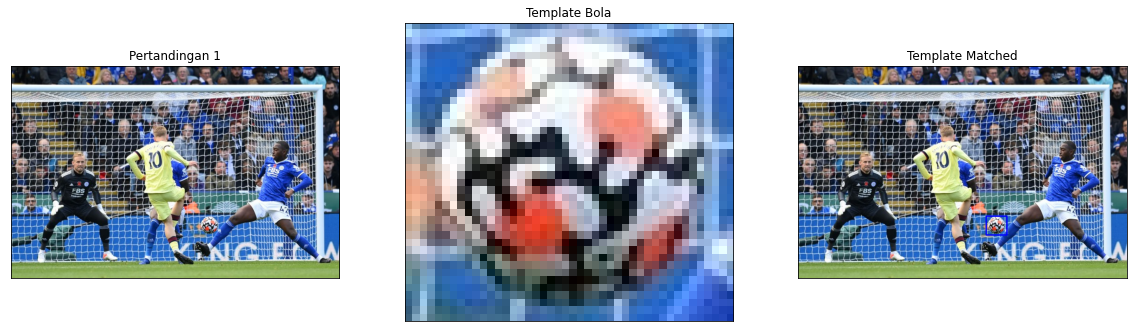

In [146]:
# Menampilkan citra
plt.figure(figsize=(20,10))
plt.subplot(131),plt.imshow(pertandingan_1_img)
plt.title('Pertandingan 1'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(template_bola_img)
plt.title('Template Bola'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(template_matched_1)
plt.title('Template Matched'), plt.xticks([]),
plt.yticks([])
plt.show()

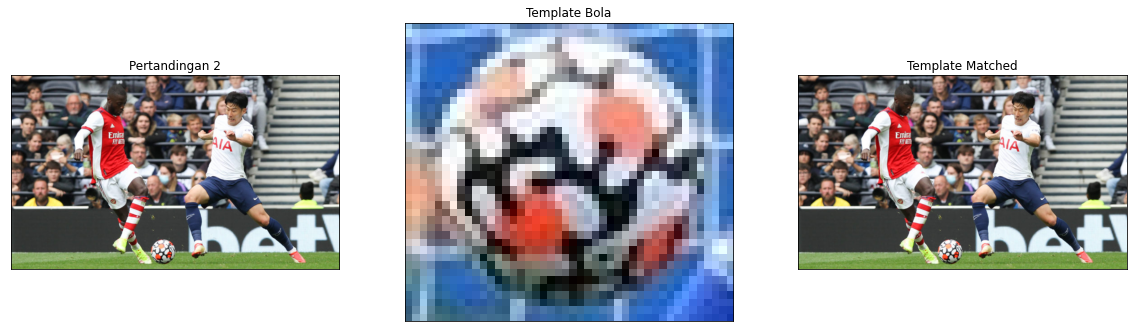

In [147]:
# Menampilkan citra
plt.figure(figsize=(20,10))
plt.subplot(131),plt.imshow(pertandingan_2_img)
plt.title('Pertandingan 2'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(template_bola_img)
plt.title('Template Bola'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(template_matched_2)
plt.title('Template Matched'), plt.xticks([]),
plt.yticks([])
plt.show()

### b. [15] Berdasarkan eksplorasi di poin a, perbedaan apa yang Anda temukan? Mengapa perbedaan ini terjadi?

Pada template matching pertandingan 1 dan 2 yang dilakukan di butir a, didapatkan bahwa hasil matching hanya terdapat pada pertandingan 1.

Hal ini terjadi karena pada pertandingan 2, dapat terlihat bahwa posisi bola dan latar bola pada foto pertandingan 2 berbeda dengan yang ada pada template.

### c. [10] Menurut Anda, apakah kelebihan dan kekurangan metode fitur ekstraksi ini? Apakah untuk kasus template matching untuk bola pada gambar pertandingan sepak bola cocok?

Kelebihannya mungkin pendekatan template matching berguna pada image yang static dan sisinya sama ketika dilihat dari berbagai sudut pandang.

Kekurangannya, template matching akan berpotensi menjadi tidak akurat pada objek yang bergerak, atau objek yang dapat dilihat dari sudut pandang yang banyak.

Mengetahui salah satu tujuan dari template matching, yakni untuk mencari lokasi template image yang lain yang bercocokan. Dan untuk kasus pertandingan sepak bola, yang mana hanya ada sedikit momen di mana citra yang diambil padanya bersifat statik (misalnya bola dan pemain akan terus bergerak selama 90 menit pertandingan), sepertinya akan sulit untuk mengimplementasikan template matching berdasarkan tujuannya. Dalam artian, akan ada banyak celah di mana gambar yang seharusnya matching akan menjadi tidak match karena banyak faktor.